# Generating points

In [81]:
import sys
import math 
import random 
import time 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import carla

#  Trying to import the Global and Local 
sys.path.append(("C:/CARLA/WindowsNoEditor/PythonAPI/carla"))
from agents.navigation.global_route_planner import GlobalRoutePlanner


''' Connecting to Carla and fetching blue-print of the map'''

# Connect the client and set up bp library and spawn point
client = carla.Client('localhost', 2000)
client.set_timeout(20.0)
world = client.get_world()
bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 


settings = world.get_settings()
settings.no_rendering_mode = False
world.apply_settings(settings)

16243

In [82]:
# start_location=carla.Transform(carla.Location(x=67.659744, y=69.822777, z=0.600000), carla.Rotation(pitch=0.000000, yaw=0.073273, roll=0.000000))
# end_location = carla.Transform(carla.Location(x=-67.254570, y=27.963758, z=0.600000), carla.Rotation(pitch=0.000000, yaw=0.159198, roll=0.000000))
start_location = random.choice(spawn_points)
print(start_location)
end_location = random.choice(spawn_points)
print(end_location)
start_point = start_location.location
end_point = end_location.location

Transform(Location(x=74.798752, y=28.343533, z=0.600000), Rotation(pitch=0.000000, yaw=0.159198, roll=0.000000))
Transform(Location(x=102.930038, y=-9.381519, z=0.600000), Rotation(pitch=0.000000, yaw=90.390709, roll=0.000000))


In [83]:
Kdd = 0.4
FPS = 30
dt  = 1./FPS
L = 2.875 #### Will need to check how to get 
sampling_resolution = 1


In [84]:
def get_target_wp_index(veh_location, waypoint_list):
    ''' 
    Try to implement next target index using this method
    http://paulbourke.net/geometry/pointlineplane/

    return:
    idx = index of the waypoint
    (tx,ty) = the target coordinate
    info (bool) =  true if last waypoint is clicked 

    Implementation given here
    '''
    print(f'the last location in the list {waypoint_list[-1]}')
    info = False
    exception = False
    dxl, dyl = [], []
    for i in range(len(waypoint_list)):
        dx = abs(veh_location.x - waypoint_list[i][0])
        dxl.append(dx) #list of dx1
        dy = abs(veh_location.y - waypoint_list[i][1])
        dyl.append(dy)

    dist = np.hypot(dxl, dyl)
    try:
        idx = np.argmin(dist) + 4 
    except: idx = 4
    # take closest waypoint, else last wp

    if idx < len(waypoint_list):
        print(f'This line is printed')
        tx = waypoint_list[idx][0]
        ty = waypoint_list[idx][1]

    else:
        print(f'the exception is printed')
        tx = waypoint_list[-1][0]
        ty = waypoint_list[-1][1]
        exception = True
    print(f'The current waypoint is {(tx, ty)}, and the indexis = {idx}')

    if (tx, ty) == waypoint_list[-1] :
        print("This is the new condition tyhat was printed")
        info = True
    return idx, (tx, ty), info

In [85]:
def process_img(image):
    i = np.array(image.raw_data)
    i2 = i.reshape((IM_HEIGHT, IM_WIDTH, 4))
    i3 = i2[:, :, :3]
    # cv2.imshow("", i3)
    # cv2.waitKey(1)
    return i3/255.0

'''SPAWNING'''
actor_lst = list()


'''spawning vehicle'''


v_bp = bp_lib.filter('vehicle.tesla.model3')[0]

vehicle = world.try_spawn_actor(v_bp,start_location)
actor_lst.append(vehicle)



'''Adding a sensor '''
IM_WIDTH = 640
IM_HEIGHT = 480
camera_bp = bp_lib.find("sensor.camera.rgb")
camera_bp.set_attribute('image_size_x', f'{IM_WIDTH}')
camera_bp.set_attribute('image_size_y', f'{IM_HEIGHT}')
camera_bp.set_attribute('fov', '110')


 # Adjust sensor relative to vehicle
camera_spawn = carla.Transform(carla.Location(x=-4, z=2.5))

# spawn the sensor and attach to vehicle.
sensor = world.try_spawn_actor(camera_bp, camera_spawn, attach_to=vehicle)

# add sensor to list of actors
actor_lst.append(sensor)

# do something with this sensor
sensor.listen(lambda data: process_img(data))


In [86]:
'''Tracing a route between the two specified point '''

 
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
route =  grp.trace_route(start_point, end_point)

''' This is just to visualize the route'''
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=60.0,
        persistent_lines=True)
    
print("Done")

waypoint_lst = []
i = 0
for waypoint, _ in route:
    i+=1
    loc = waypoint.transform.location
    waypoint_lst.append((loc.x,loc.y)) 
    
print(len(waypoint_lst),i)
    # print(asadbhai)

Done
509 509


In [87]:
'''spectator mode'''


transform = carla.Transform()
transform.rotation.yaw = 180
transform.rotation.pitch = 0
transform.rotation.roll = 0

spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-5,z=20)), carla.Rotation(yaw=90, pitch=-90)) 
spectator.set_transform(transform)


In [88]:
target_lst = []
j= 0
epsilon = [1,2,3,4,5]
string_lst = []

Changing the ld from kdd*vel to 6.3 makes a difference


In [89]:
''' Creating a pure persuit controller
The target here would be the rear vehicle
'''



##### Start Your Engines #########
control = carla.VehicleControl()
control.throttle = 0.5
vehicle.apply_control(control)

implemented_route = []
Error_cal = [] # store lateral error and the index
from tqdm import tqdm
print(f"The way point list lenghth is {len(waypoint_lst)}")
for t in range(len(waypoint_lst)):
    print(f't = {t}')
    # throttle, steer = controller.get_control(traj, speed, desired_speed=25, dt=1./FPS)

    ###### Geting Current information #########
    vehicle_transform = vehicle.get_transform()
    loc = vehicle_transform.location
    x_,y_,z_ = (loc.x,loc.y,loc.z)
    vel_array = vehicle.get_velocity() 
    x_dot, y_dot, z_dot = (vel_array.x, vel_array.y, vel_array.z)
    vel = np.hypot(x_dot, y_dot)
    
    implemented_route.append((x_,y_))
    
    print(f"The velocity = {vel}")

    yaw = vehicle_transform.rotation.yaw
    yaw = np.radians(yaw)  ### Converting in radians




    _, target, is_end = get_target_wp_index(loc, waypoint_lst)
    if is_end:
        print("You have reached your destination") 
        control.brake = True
        break
    # target = waypoint_lst[t]
    tx, ty = target
    rand = random.randint(1, 5)        
    if rand == random.choice(epsilon):
      choice_num = random.randint(1, 3)
      tx, ty =  [(x_ - 1, y_ + 1),(x_, y_ + 1),(x_ + 1, y_ + 1) ][choice_num-1]
      string_lst.append(f'The global location was {target} and the appended choice was {(tx,ty)} and choice num was {choice_num}')

    target.append((tx, ty))

    ######### Look ahead distance ##########
    # ld_approx = np.clip(Kdd * vel ,3, 30) #### Might change in the future
    # Kdd = 2/(ld_approx)**2 # Need to check if this is correct: sourc: https://www.shuffleai.blog/blog/Three_Methods_of_Vehicle_Lateral_Control.html. See section 2.4
    ld_approx = 6.3


    ######### Calculate Alpha #########3
    alpha = math.atan2((ty - y_), (tx-x_)) - yaw
    print(f"Alpha = {alpha}")

    # ld_approx = (tx-x_)/math.cos(alpha)

    error = 2 * math.sin(alpha)/ld_approx
    Error_cal.append(error)
    print(f"The error is {error}")


    ############### Steering Angle ####################3
    del_ = np.clip(math.atan2(2*L*math.sin(alpha),ld_approx ),-1,1)
    print(f'Steering angle = {del_}')

    control.steer = del_
    vehicle.apply_control(control)


    print('-----------------------')
    
    time.sleep(0.5)
    
control.throttle = 0
vehicle.apply_control(control)
    

The way point list lenghth is 509
t = 0
The velocity = 4.6745762822754234e-08
the last location in the list (102.93003845214844, -9.381519317626953)
This line is printed
The current waypoint is (78.403564453125, 28.40188217163086), and the indexis = 4
Alpha = 0.01340664402285473
The error is 0.004255949972169673
Steering angle = 0.012235245589635641
-----------------------
t = 1
The velocity = 4.110241000535006e-08
the last location in the list (102.93003845214844, -9.381519317626953)
This line is printed
The current waypoint is (78.403564453125, 28.40188217163086), and the indexis = 4
Alpha = 0.01340664402285473
The error is 0.004255949972169673
Steering angle = 0.012235245589635641
-----------------------
t = 2
The velocity = 6.213408593428e-08
the last location in the list (102.93003845214844, -9.381519317626953)
This line is printed
The current waypoint is (78.403564453125, 28.40188217163086), and the indexis = 4
Alpha = 0.01340664402285473
The error is 0.004255949972169673
Steerin

KeyboardInterrupt: 

In [90]:
# vehicle.destroy()
''' Destroy everything'''
try:
    car_lst = world.get_actors().filter('vehicle.*')
    print(car_lst)
    if car_lst:
        for car in car_lst:
            car.destroy()
except:
    print("Nope doesnt work")

for act in actor_lst:
    try: 
        print(act)
        act.destroy()
        print("Those this way")
    except:
        pass

[Actor(id=30, type=vehicle.tesla.model3)]
Actor(id=30, type=vehicle.tesla.model3)


Those this way
Actor(id=31, type=sensor.camera.rgb)
Those this way


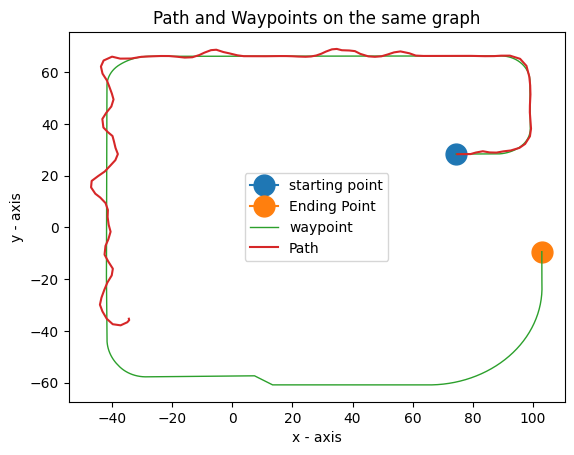

In [91]:
x_way = []
y_way = []
x_real = []
y_real = []
for x, y in waypoint_lst:
    x_way.append(x)
    y_way.append(y)

for x, y in implemented_route:
    x_real.append(x)
    y_real.append(y)
plt.plot(x_way[0], y_way[0], label = "starting point", marker = 'o',markersize = 15)
plt.plot(x_way[-1], y_way[-1], label = "Ending Point", marker = 'o',markersize = 15)
plt.plot(x_way, y_way, label = "waypoint", linewidth = 1)
plt.plot(x_real, y_real, label = 'Path')

# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Path and Waypoints on the same graph')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()



In [92]:
for lst in string_lst:
    print(lst)

The global location was (83.0335464477539, 28.41474723815918) and the appended choice was (80.23662567138672, 29.390050888061523) and choice num was 3
The global location was (89.76258087158203, 28.576255798339844) and the appended choice was (85.5616455078125, 30.021379470825195) and choice num was 2
The global location was (59.98227310180664, 66.32524871826172) and the appended choice was (63.56504821777344, 67.34609985351562) and choice num was 2
The global location was (46.05228042602539, 66.30743408203125) and the appended choice was (50.61085510253906, 67.2210922241211) and choice num was 3
The global location was (41.05228805541992, 66.30104064941406) and the appended choice was (44.23286437988281, 67.19449615478516) and choice num was 1
The global location was (35.05229187011719, 66.29336547851562) and the appended choice was (38.910648345947266, 69.4618148803711) and choice num was 2
The global location was (0.14231696724891663, 66.24873352050781) and the appended choice was (

23 23 23 23


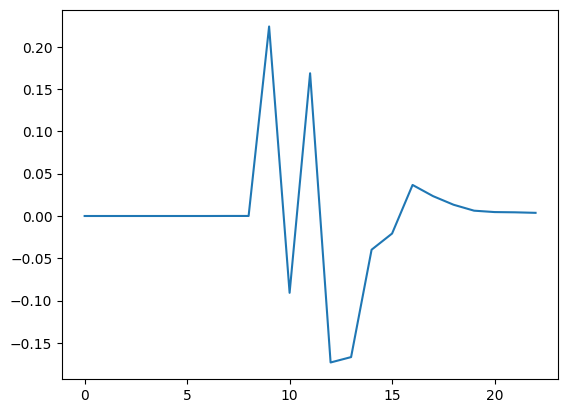

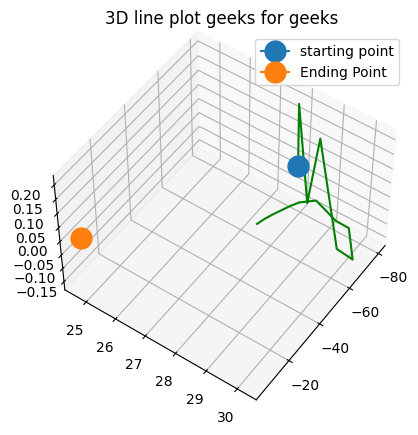

In [ ]:
# error_plot = plt.figure()
# print(error_plot)
# error_plot.
from mpl_toolkits import mplot3d
plt.plot(Error_cal, label = "error")
print(len(Error_cal), len(x_real),len(y_real), len(x_way))

fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = np.linspace(0, 1, 100)
x = z * np.sin(25 * z)
y = z * np.cos(25 * z)
 
# plotting
ax.plot3D(x_real, y_real, Error_cal, 'green')
ax.plot3D(x_way[0], y_way[0],Error_cal[0], label = "starting point", marker = 'o',markersize = 15)
ax.plot3D(x_way[-1], y_way[-1], Error_cal[-1], label = "Ending Point", marker = 'o',markersize = 15)
ax.set_title('3D line plot geeks for geeks')
ax.view_init(50, 35)
plt.legend()
plt.show()

In [ ]:
settings.no_rendering_mode = False
world.apply_settings(settings)


12822